In [6]:
import boto3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import precision_recall_cutoff as prc
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from tqdm import tqdm


# Defining the s3 bucket
s3 = boto3.resource('s3')
bucket_name = 'data-445-wagner'
bucket = s3.Bucket(bucket_name)

# Defining the file to be read from s3 bucket
file_key = "train.csv"

bucket_object = bucket.Object(file_key)
file_object = bucket_object.get()
file_content_stream = file_object.get('Body')

# Reading the csv file
train = pd.read_csv(file_content_stream, sep = '|')

# Defining the file to be read from s3 bucket
file_key1 = "test.csv"

bucket_object1 = bucket.Object(file_key1)
file_object1 = bucket_object1.get()
file_content_stream1 = file_object1.get('Body')

# Reading the csv file
test = pd.read_csv(file_content_stream1, sep = '|')
test.head()

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition
0,4,467,88.48,4,8,4,0.014989,0.189465,0.571429
1,3,1004,58.99,7,6,1,0.026892,0.058755,0.259259
2,1,162,14.00,4,5,4,0.006173,0.086420,4.000000
3,5,532,84.79,9,3,4,0.026316,0.159380,0.642857
4,5,890,42.16,4,0,0,0.021348,0.047371,0.210526


In [7]:
#creating variables from last homework
#Creating features for training
train['Interaction_1'] = np.where((train['trustLevel'] <= 1.5) & (train['scannedLineItemsPerSecond'] <= 0.012) & (train['lineItemVoids'] <= 10.5), 1, 0)
train['Interaction_2'] = np.where((train['trustLevel'] <= 1.5) & (train['scannedLineItemsPerSecond'] <= 0.012) & (train['lineItemVoids'] >= 10.5), 1, 0)
train['Interaction_3'] = np.where((train['trustLevel'] <= 1.5) & (train['scannedLineItemsPerSecond'] >= 0.012) & (train['totalScanTimeInSeconds'] <= 895.0), 1, 0)
train['Interaction_4'] = np.where((train['trustLevel'] <= 1.5) & (train['scannedLineItemsPerSecond'] >= 0.012) & (train['totalScanTimeInSeconds'] >= 895.0), 1, 0)
train['Interaction_5'] = np.where((train['trustLevel'] >= 1.5) & (train['trustLevel'] <= 2.5) & (train['totalScanTimeInSeconds'] <= 1298.0), 1, 0)
train['Interaction_6'] = np.where((train['trustLevel'] >= 1.5) & (train['trustLevel'] <= 2.5) & (train['totalScanTimeInSeconds'] >= 1298.0), 1, 0)
train['Interaction_7'] = np.where((train['trustLevel'] >= 1.5) & (train['trustLevel'] >= 2.5), 1, 0)

#Creating features for test
test['Interaction_1'] = np.where((test['trustLevel'] <= 1.5) & (test['scannedLineItemsPerSecond'] <= 0.012) & (test['lineItemVoids'] <= 10.5), 1, 0)
test['Interaction_2'] = np.where((test['trustLevel'] <= 1.5) & (test['scannedLineItemsPerSecond'] <= 0.012) & (test['lineItemVoids'] >= 10.5), 1, 0)
test['Interaction_3'] = np.where((test['trustLevel'] <= 1.5) & (test['scannedLineItemsPerSecond'] >= 0.012) & (test['totalScanTimeInSeconds'] <= 895.0), 1, 0)
test['Interaction_4'] = np.where((test['trustLevel'] <= 1.5) & (test['scannedLineItemsPerSecond'] >= 0.012) & (test['totalScanTimeInSeconds'] >= 895.0), 1, 0)
test['Interaction_5'] = np.where((test['trustLevel'] >= 1.5) & (test['trustLevel'] <= 2.5) & (test['totalScanTimeInSeconds'] <= 1298.0), 1, 0)
test['Interaction_6'] = np.where((test['trustLevel'] >= 1.5) & (test['trustLevel'] <= 2.5) & (test['totalScanTimeInSeconds'] >= 1298.0), 1, 0)
test['Interaction_7'] = np.where((test['trustLevel'] >= 1.5) & (test['trustLevel'] >= 2.5), 1, 0)

In [11]:
# Defining variables
X = train.drop(columns = ['fraud'])
Y = train['fraud']

#Identifying top features
results = list()

for i in tqdm(range(0, 100)):
   #Splitting the data
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, stratify = Y)
    
    #Building the random forest model
    RF = RandomForestClassifier(max_depth = 3, n_estimators = 500).fit(X_train, Y_train)
    
    #Extracting feature importances
    results.append(RF.feature_importances_)

#Changing to data frame
results = pd.DataFrame(results)
results.columns = X.columns


#computing averages and sorting importances
results = pd.DataFrame(results.apply(np.mean, axis = 0))
results = pd.DataFrame({'Feature': results.index, 'Importance': results[0].values})
results = results.sort_values(by = 'Importance', ascending = False)
results


100%|██████████| 100/100 [01:18<00:00,  1.28it/s]


,Feature,Importance
12,Interaction_4,0.379008
0,trustLevel,0.174601
15,Interaction_7,0.093014
6,scannedLineItemsPerSecond,0.080115
8,lineItemVoidsPerPosition,0.054621
1,totalScanTimeInSeconds,0.051120
11,Interaction_3,0.034981
7,valuePerSecond,0.027204
2,grandTotal,0.020192
3,lineItemVoids,0.018780


In [12]:
#Top 3 variables are interaction 4, trustLevel, and interaction7
#engineering 3 features with strong heredity principle
train['feature1'] = train['Interaction_4'] * train['trustLevel']
train['feature2'] = train['Interaction_4'] * train['Interaction_7']
train['feature3'] = train['trustLevel'] * train['Interaction_7']

[Text(558.0, 856.1700000000001, 'Interaction_4 <= 0.5\ngini = 0.104\nsamples = 1503\nvalue = [1420, 83]'),
 Text(279.0, 611.55, 'Interaction_3 <= 0.5\ngini = 0.05\nsamples = 1440\nvalue = [1403, 37]'),
 Text(139.5, 366.93000000000006, 'Interaction_6 <= 0.5\ngini = 0.022\nsamples = 1330\nvalue = [1315, 15]'),
 Text(69.75, 122.30999999999995, 'gini = 0.003\nsamples = 1243\nvalue = [1241, 2]'),
 Text(209.25, 122.30999999999995, 'gini = 0.254\nsamples = 87\nvalue = [74, 13]'),
 Text(418.5, 366.93000000000006, 'lineItemVoidsPerPosition <= 0.429\ngini = 0.32\nsamples = 110\nvalue = [88, 22]'),
 Text(348.75, 122.30999999999995, 'gini = 0.418\nsamples = 74\nvalue = [52, 22]'),
 Text(488.25, 122.30999999999995, 'gini = 0.0\nsamples = 36\nvalue = [36, 0]'),
 Text(837.0, 611.55, 'totalScanTimeInSeconds <= 1320.0\ngini = 0.394\nsamples = 63\nvalue = [17, 46]'),
 Text(697.5, 366.93000000000006, 'scannedLineItemsPerSecond <= 0.017\ngini = 0.5\nsamples = 26\nvalue = [13, 13]'),
 Text(627.75, 122.3099

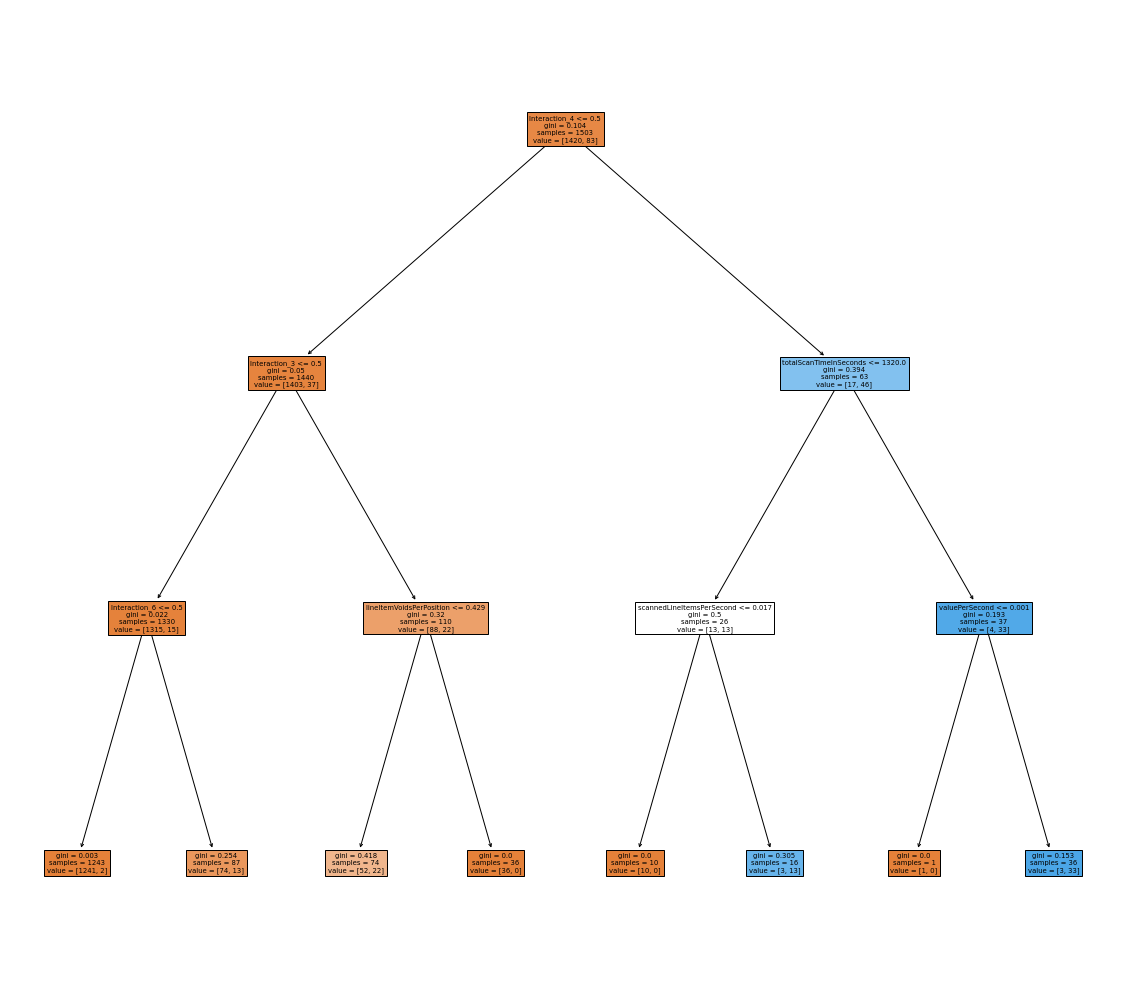

In [13]:
# Defining variables
X = train.drop(columns = ['fraud'])
Y = train['fraud']

#Building model for decision tree
md1 = DecisionTreeClassifier(max_depth = 3).fit(X_train, Y_train)

#Visualizing model
fig = plt.figure(figsize = (20, 18))
plot_tree(md1, feature_names = X_train.columns, filled = True)

In [14]:
#Creating features for training based off of decision tree
#highest number of samples for first interaction
train['newInteraction_1'] = np.where((train['Interaction_4'] <= 0.5) & (train['Interaction_3'] <= 0.5) & (train['Interaction_6'] <= 0.5), 1, 0)
#second highest number of samples for second interaction
train['newInteraction_2'] = np.where((train['Interaction_4'] <= 0.5) & (train['Interaction_3'] <= 0.5) & (train['Interaction_6'] >= 0.5), 1, 0)
#third highest number of samples for third interaction
train['newInteraction_3'] = np.where((train['Interaction_4'] <= 0.5) & (train['Interaction_3'] >= 0.5) & (train['lineItemVoidsPerPosition'] <= 0.429), 1, 0)

In [15]:
#engineering features for test data frame
test['feature1'] = test['Interaction_4'] * test['trustLevel']
test['feature2'] = test['Interaction_4'] * test['Interaction_7']
test['feature3'] = test['trustLevel'] * test['Interaction_7']

test['newInteraction_1'] = np.where((test['Interaction_4'] <= 0.5) & (test['Interaction_3'] <= 0.5) & (test['Interaction_6'] <= 0.5), 1, 0)
test['newInteraction_2'] = np.where((test['Interaction_4'] <= 0.5) & (test['Interaction_3'] <= 0.5) & (test['Interaction_6'] >= 0.5), 1, 0)
test['newInteraction_3'] = np.where((test['Interaction_4'] <= 0.5) & (test['Interaction_3'] >= 0.5) & (test['lineItemVoidsPerPosition'] <= 0.429), 1, 0)


In [16]:
#Testing model with/without the new features
# Defining variables
X = train.drop(columns = ['fraud'])
Y = train['fraud']

#Splitting the data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, stratify = Y)

In [17]:
#buiding model with all variables
#Building random forest model  
RF1 = RandomForestClassifier(n_estimators = 500, max_depth = 3).fit(X_train, Y_train)

#Predicting test
RF1_pred = RF1.predict_proba(X_test)[:, 1]

#Predicting labels
RF1_labels =prc.precision_recall_cutoff(Y_test, RF1_pred)

#Printing classification report
print(classification_report(Y_test, RF1_labels))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       355
           1       0.88      0.71      0.79        21

    accuracy                           0.98       376
   macro avg       0.93      0.85      0.89       376
weighted avg       0.98      0.98      0.98       376



In [18]:
#Building model without new variables
#defining variables
X_train = X_train.drop(columns = ['feature1', 'feature2', 'feature3','newInteraction_1', 'newInteraction_2', 'newInteraction_3'])
X_test = X_test.drop(columns = ['feature1', 'feature2', 'feature3','newInteraction_1', 'newInteraction_2', 'newInteraction_3'])

#Building random forest model  
RF2 = RandomForestClassifier(n_estimators = 500, max_depth = 3).fit(X_train, Y_train)

#Predicting test
RF2_pred = RF2.predict_proba(X_test)[:, 1]

#Predicting labels
RF2_labels =prc.precision_recall_cutoff(Y_test, RF2_pred)

#Printing classification report
print(classification_report(Y_test, RF2_labels))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       355
           1       0.80      0.76      0.78        21

    accuracy                           0.98       376
   macro avg       0.89      0.88      0.88       376
weighted avg       0.98      0.98      0.98       376



In [ ]:
#Random forrest model with all the new variables is slightly better than the original